In [59]:
import numpy as np
from ksvd import ApproximateKSVD
import nibabel as nib
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

X = np.random.randn(1000, 20)

In [21]:
space = np.linspace(50, 200, 10).astype('int')
errors = []
for val in space:
    aksvd = ApproximateKSVD(n_components=val)
    dictionary = aksvd.fit(X).components_
    gamma = aksvd.transform(X)
    error = np.abs(gamma @ dictionary - X).mean()
    errors.append(error)

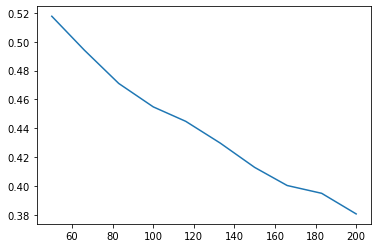

In [22]:
plt.plot(space, errors)

In [134]:
def get_data(filename: str) -> np.ndarray:
    file = nib.load(filename)
    data = file.get_fdata()
    return data

def plot_data(data: np.ndarray, scale: float=0.1, dim: int=0, slice: int=50, show=True) -> None:
    shape = list(data.shape)
    shape.pop(dim)
    imgsize = np.multiply(shape, scale)
    if show:
        plt.figure(figsize=imgsize)
    if dim == 0:
        data = data[slice, :, :]
    elif dim == 1:
        data = data[:, slice, :]
    elif dim == 2:
        data = data[:, :, slice]
    else:
        raise ValueError('Wrong dim argument')
    plt.imshow(data)
    if show:
        plt.show()

In [158]:
data_dis = get_data('/home/alexkkir/ai-masters/linal/project/t1_icbm_normal_1mm_pn3_rf20.mnc')
data_ref = get_data('/home/alexkkir/ai-masters/linal/project/t1_icbm_normal_1mm_pn0_rf20.mnc')

MEAN = data_dis.mean()
STD = data_dis.std()

data_dis = (data_dis - MEAN) / STD
data_ref = (data_ref - MEAN) / STD

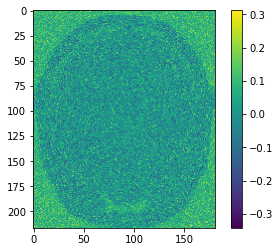

In [159]:
plot_data(data_dis - data_ref, show=False)
plt.colorbar()

In [150]:
np.square(data_dis - data_ref)[0, :25, :25].mean(), np.square(data_dis - data_ref)[0, 50:75, 50:75].mean()

(821.3323014942969, 457.12511891785067)

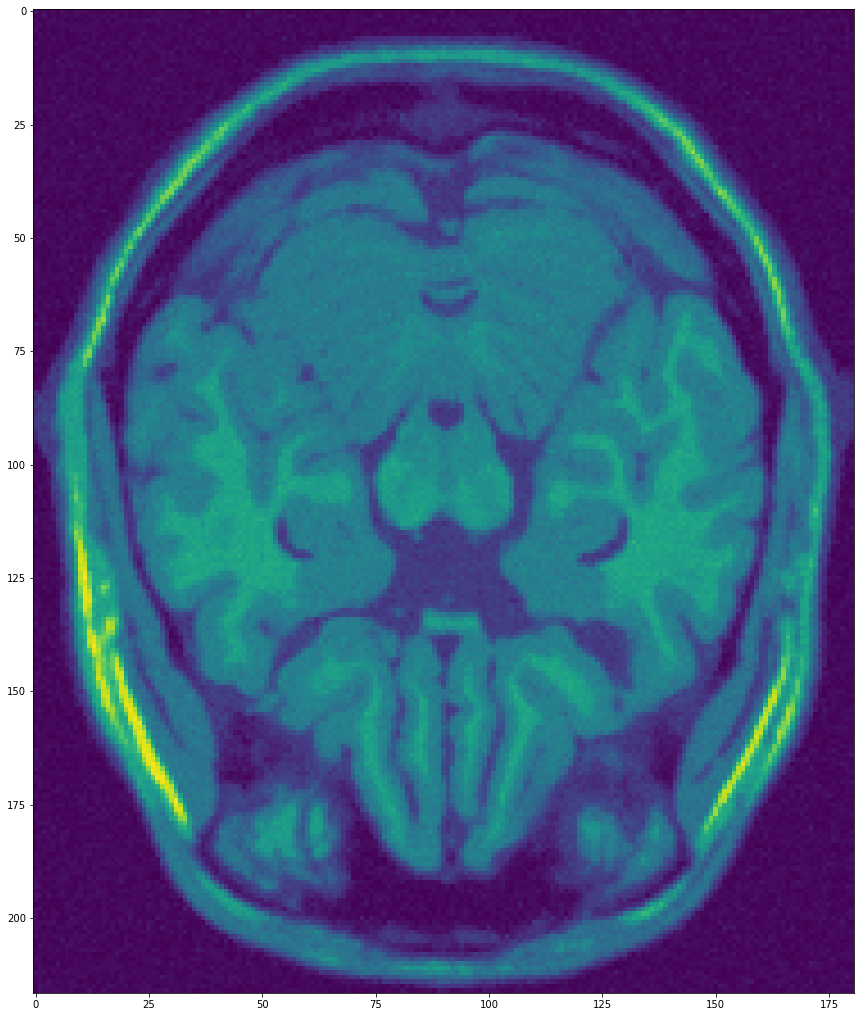

In [34]:
plot_data(data_dis, dim=0)

In [312]:
def split_data_to_blocks_2d(data: np.ndarray, block_size, stride):
    tmp = sliding_window_view(data, (block_size, block_size))[::stride, ::stride]
    shape = tmp.shape
    # tmp = tmp.reshape(tmp.shape[0] * tmp.shape[1], tmp.shape[2] * tmp.shape[3])
    return tmp, shape

def split_data_to_blocks_3d(data: np.ndarray, block_size, stride):
    return sliding_window_view(data, (block_size, block_size, block_size))[::stride, ::stride, ::stride]

def merge_blocks_2d_no_overlap(blocks, shape):
    x = blocks.reshape(shape)
    x = x.swapaxes(1, 2)
    x = x.reshape((shape[0] * shape[2], shape[1] * shape[3]))
    return x

def combine_blocks_2d_to_layers_with_stride_1(blocks, shape):
    n, m, block_size, _ = shape
    n = (n + block_size - 1)
    m = (m + block_size - 1)
    x = blocks.reshape(shape)
    layers = [None] * (block_size ** 2)
    for layer_id in range(len(layers)):
        i = layer_id // block_size
        j = layer_id % block_size
        layer = blocks[i::block_size, j::block_size]
        layer = layer.swapaxes(1, 2)
        layer = layer.reshape((layer.shape[0] * layer.shape[1], layer.shape[2] * layer.shape[3]))
        layer = np.pad(
            layer, 
            ((i, n - layer.shape[0] - i), (j, m - layer.shape[1] - j)),
            mode='constant',
            constant_values=np.nan # values for which we don't have value we mask with np.nan
        )
        layers[layer_id] = layer
    return layers

def merge_layers_2d_stide_1(layers):
    layers = np.array(layers)
    mask = ~np.isnan(layers)
    layers[~mask] = 0
    mask = mask.mean(axis=0)
    layers = layers / mask
    layers = layers.mean(axis=0)
    return layers

def merge_blocks_2d_stide_1(blocks, shape):
    layers = combine_blocks_2d_to_layers_with_stride_1(blocks, shape)
    merged = merge_layers_2d_stide_1(layers)
    return merged

In [313]:
image = data_dis[0]
blocked_data, shape = split_data_to_blocks_2d(image, 4, 1)
merged_data = merge_blocks_2d_stide_1(blocked_data, shape)

In [314]:
np.allclose()

(0.20448120660627003, 0.2044812066062701)

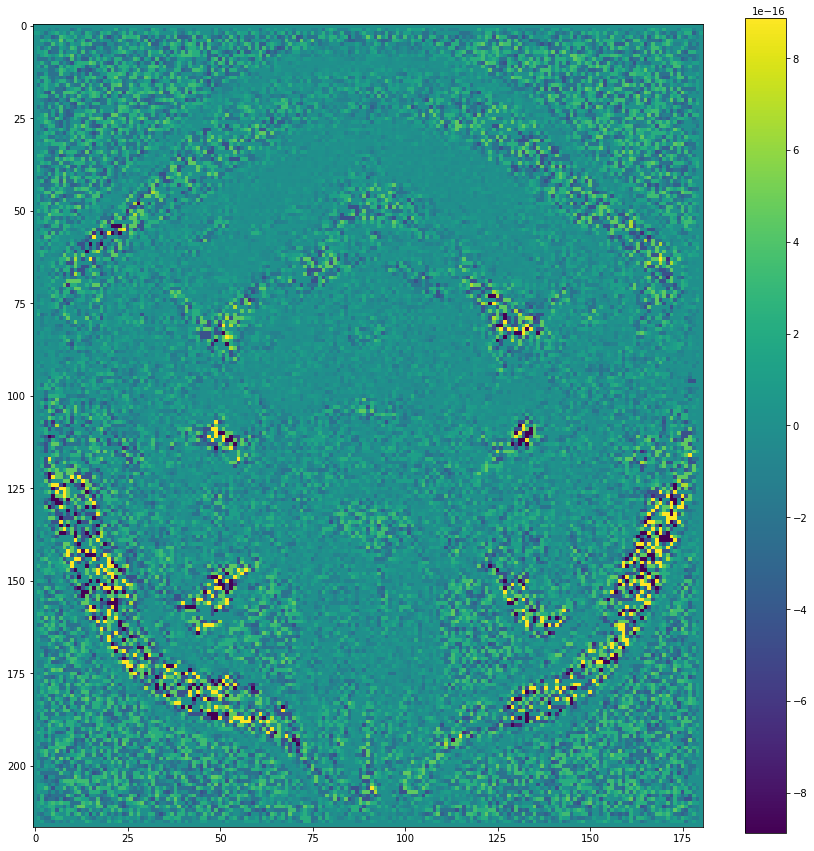

In [310]:
plt.figure(figsize=(15, 15))
plt.imshow(merged_data - image)
plt.colorbar()

In [267]:
out[0][-4:, -4:]

array([[-0.9575071 , -0.94319344, -0.92683497,  0.        ],
       [-0.89718524, -0.93296939, -0.86651311,  0.        ],
       [-0.86140109, -0.8879836 , -0.9350142 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [270]:
[x % 4 for x in data_dis[0].shape]

[1, 1]

0.06319000380632606 0.1


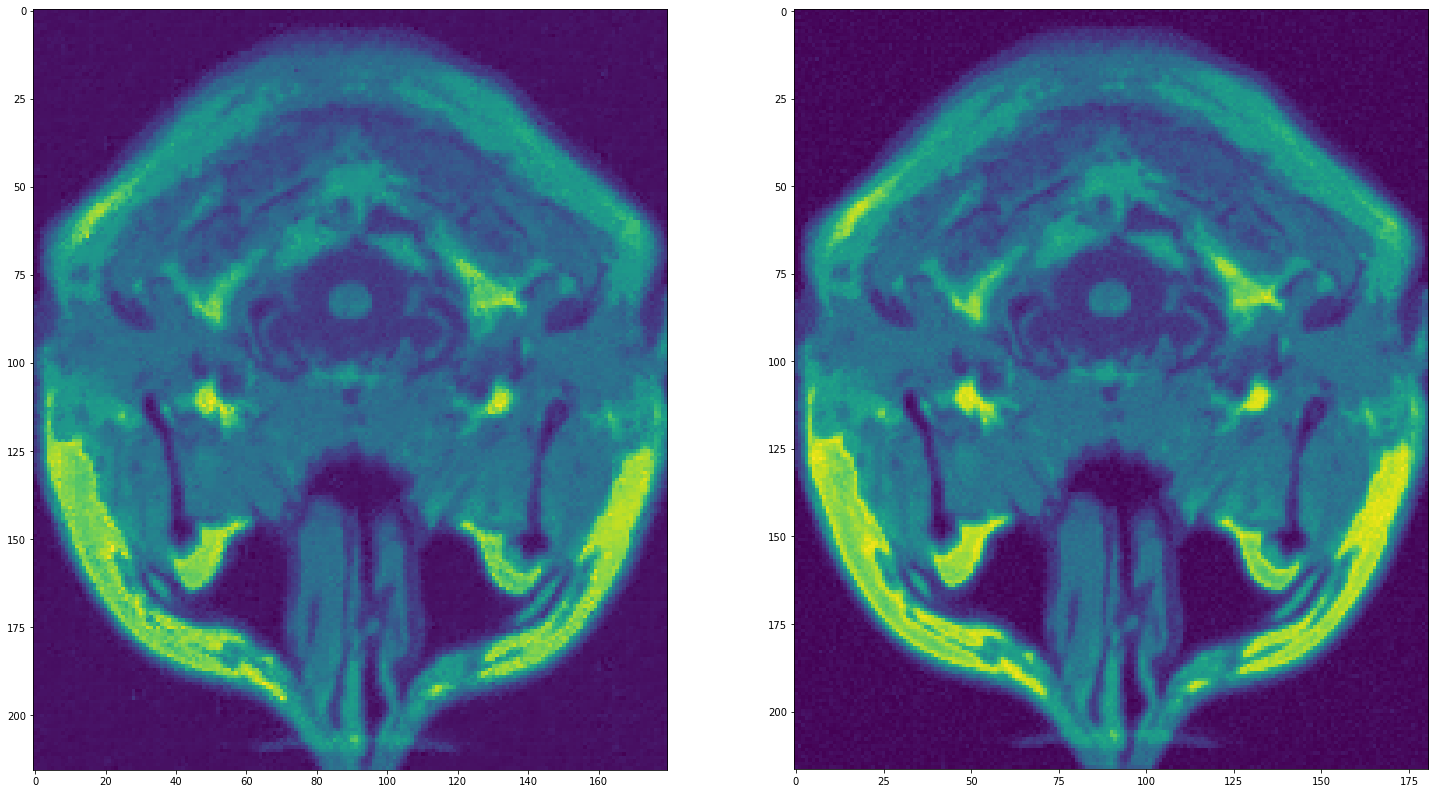

In [196]:
aksvd = ApproximateKSVD(n_components=50, transform_n_nonzero_coefs=5)
dictionary = aksvd.fit(blocked_data).components_
gamma = aksvd.transform(blocked_data)
error = np.abs(gamma @ dictionary - blocked_data).mean()
print(error, (gamma != 0).sum() / gamma.size)

restored = gamma @ dictionary

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.imshow(merge_blocks_2d_no_overlap(restored, shape))
plt.subplot(1, 2, 2)
plt.imshow(data_dis[0])
plt.show()